# Reconocimiento de rostros utilizando máquinas de vectores de soporte y análisis en componentes principales.

En esta libreta vamos a hacer el clásico algritmo conocido como *eigenfaces* con el fin de ilustrar el uso de las máquinas de vector de soporte y los componentes principales. Para darle más énfasis a esto, no vamos a utilizar los métodos de análisis y optimización que ya existen en Scikit learn.

In [169]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from gzip import GzipFile  #  Para abrir el archivo comprimido

## 1.  Carga imágenes y nombres a partir de los archivos

Para este problema, se utilizaron ejemplos del conjunto de imagenes
[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz), 
el cual tiene un tamaño de 233MB.

Los datos preprocesados se obtuvieron de la librería de bases de datos de
prueba de [scikit.learn](http://sourceforge.net/projects/scikit-learn/files/data/), 
pero los presentamos en esta libreta por separado, con el fn de mostrar un poco el proceso
completo paso a paso.
  
Para preprocesar las imagenes, se utilizó [openCV](http://opencv.willowgarage.com/wiki/Welcome).
En cada imagen:

1. Se utilizó *OpenCV* para localizar y extraer el rostro

2. Se recortó y escaló a una resolución de 64x64 pixeles

3. Se convirtió a escala de grises

4. Se transformó a un arreglo tipo *numpy*

5. Se colocaron una imagen sobre otra 

6. Se guardo como un archivo de numpy (usando np.save)

7. Se comprimió el archivo usando el método gzip (sin comprimir son 250 Mb).

El archivo es ``faces.npy.gz``

Los nombres de las imágenes (donde se puede extraer el nombre
de la persona que aparece) se guardó en el archivo texto ``face_filenames.txt``


In [170]:
caras = np.load(GzipFile("faces.npy.gz"))

nombre_caras = [l.strip().rsplit('_',1)[0]
                for l in open("face_filenames.txt").readlines()]


# A cada cara se le quita el brillo restandole el
# valor medio de brillo de cada una.
caras = caras - caras.mean(axis=1).reshape(caras.shape[0],1)


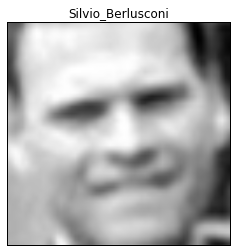

In [171]:
# Ejemplo para ver las imagenes

ej = np.random.randint(caras.shape[0])
imagen_ejemplo = np.reshape(caras[ej,:].copy(), (64,64))
plt.imshow(imagen_ejemplo, cmap=plt.cm.gray)
plt.title(nombre_caras[ej])
plt.xticks(())
plt.yticks(())
plt.show()


## 2. Acondicionamiento de los datos de objetivos T 


Una vez que se tiene bien establecido el objetivo, entonces
hay que generar el vector Y de salidas o *targets*.

Para esto vamos a utilizar varias operaciones de ``numpy`` que
no habíamos utilizado antes.

- ``np.unique(A)`` devuelve un vector con los valores diferentes de A.

- ``np.searchsorted(A, V)`` regresa un vector de indices donde se encuentra cada elemento de A en V.

- ``np.bincount(X)`` cuenta el número de ocurrencias 

- ``np.in1d(A,B)`` encuentra los indices donde en A hay un elemento que se encuentra el B. Lo devuelve como
  False o True, por lo que se puede utilizar a lo largo de los renglones sin problemas.

Como se tienen demasiadas clases (una por cada nombre), lo
que vamos a hacer es reducir la complejidad del problema a
solamente clasificar los 5 rostros mas repetidos en los datos.
Así tenemos que encontrar las 5 clases con mayor frecuencia en
los datos y a partir de ahi obtener las matrices X y T para
aprendizaje.


In [172]:
# Genera el vector de targets
nombre_caras_array = np.array(nombre_caras)
caras_diferentes = np.unique(nombre_caras_array)
Y_completa = np.searchsorted(caras_diferentes, nombre_caras_array)

# Encuentra las clases (en números enteros) más repetidas en T
clases_retenidas = np.argsort(np.bincount(Y_completa))[-5:]


# Obtiene indices y extrae la nueva matriz
indices = np.in1d(Y_completa, clases_retenidas)
X = caras[indices]
Y = Y_completa[indices]
Y = Y.reshape(-1, 1) # Vector columna

# Revuelve en forma aleatoria los datos
indices = range(Y.shape[0])
np.random.shuffle(indices)
X = X[indices,:]
Y = Y[indices,:]

# Separa el 25% de los datos como datos de prueba
separa = 3 * Y.shape[0] / 4
X_e, X_t = X[:separa,:], X[separa:,:]
Y_e, Y_t = Y[:separa,:], Y[separa:,:]


# Imprime la información sobre los datos retenidos
# para aprendizaje y prueba 

print "Las caras que se repitan mas son: \n"
print caras_diferentes[clases_retenidas]
print "\nTamano del conjunto de aprendizaje:\n"
print "Numero de atributos: ", X_e.shape[1]
print "Numero de elementos para aprendizaje: ", X_e.shape[0]
print "Numero de elementos para prueba: ", X_t.shape[0]


Las caras que se repitan mas son: 

['Gerhard_Schroeder' 'Donald_Rumsfeld' 'Tony_Blair' 'Colin_Powell'
 'George_W_Bush']

Tamano del conjunto de aprendizaje:

Numero de atributos:  4096
Numero de elementos para aprendizaje:  845
Numero de elementos para prueba:  282


## 3.  Preprocesamiento de datos de entrada

Si tomamos tal cual la información para clasificación,
entonces tenemos 64 $\times$ 64 atributos (1024), de los cuales
muchos son redundantes.

Para reconocimiento de rostros se utiliza muy normalmente
una técnica conocida como *eigenfaces*, la cual no es más
que aplicar una transformación lineal conocida como **Análisis
en componentes principales** a la información que se obtiene
en un vector que representa pixeles.

El análisis en componentes principales (PCA), asume que los datos
de aprendizaje son significativos estadísticamente, por lo que
se le aplica una matriz de rotación a los datos con el fin de
buscar un cambio de coordenandas, en las cuales las covarianzas
entre cualquier par de dimensiones dimensiones diferentes sea 0. 

Para realizar el PCA hay que realizar una operación muy macabrona del
análisis numérico: la obtención de valores propios y vectores propios.
En general los algoritmos eficientes (numéricamente) solo funcionan
para matrices densas y pequeñas o para matrices muy grandes y dispersas.

``Scikit.learn`` provee tres métodos de PCA, donde solo varía la manera
en que obtiene los valores propios y vectores propios. Para no fallar,
utilizaremos ``RandomizedPCA`` que funciona tanto para matrices pequeñas y densas
como dispersas, pero que es menos eficiente que los otros dos métodos que son
especializados para cada caso.

Es importante recordar que la extracción de características y
normalización siempre se realiza asumiendo que los únicos datos
conocidos son los de aprendizaje, y luego se transforman los datos
de prueba a partir de los datos establecidos.


In [173]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 150

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)


¿Fácil, verdad? Ahora veamos que se obtuvo de esto. Recuerda que el número de componentes requeridas lo puedes variar (mientras menos componentes, menos información pero ménos parámetros necesarios en el aprendizaje, unas por otras).


Tamaño del conjunto de aprendizaje preprocesado:

Atributos:  150 	 Elementos:  845


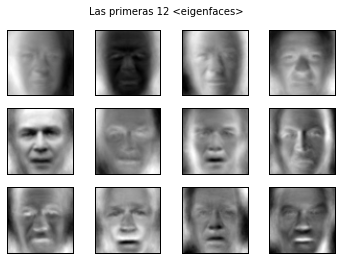

In [174]:
# Imprime la información sobre los datos preprocesados
# así como la imagen de la <<eigenface>> o máscara que
# permite encontrar los componentes más determinantes
# para encontrar diferencias entre los datos. 

print "\nTamaño del conjunto de aprendizaje preprocesado:\n"
print "Atributos: ", X_e_pca.shape[1], "\t Elementos: ", X_e_pca.shape[0]

# Se obtienen las "Caras genéricas (una por componente principal)"
# solo para ver las caras más genérica por curiosidad
eigenfaces = pca.components_.reshape((componentes_principales, 64, 64))

columnas, renglones = 4, 3
for i in range(columnas * renglones):
    plt.subplot(renglones, columnas, i + 1)
    plt.imshow(eigenfaces[i,:,:].copy().squeeze(), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Las primeras 12 <eigenfaces>")
plt.show()

## 4. Clasificación utilizando una Máquina de vectores de soporte lineal

Vamos ahora a utilizar la máquina de vectes de soporte sin el truco del kernel, o lo que es lo mismo, con un kernel lineal. Para esto vamos a utilizar la máquina de vector de soporte que viene incluida en la librería de ``scikit-learn``. Es de tener en cuenta que para los clasificadores que solo usan Kernel lineal existe su propia función, la cual se encuentra optimizada, a diferencia que la función que utiliza el truco del kernel, la cual no se puede optimizar (en velocidad de ejecución tanto). 



In [175]:
# Esta es la clase de clasificadores tipo SVM con kernel lineal
from sklearn.svm import LinearSVC

# Ahora vamos a obtener las funciones para evaluar un clasificador
from sklearn.metrics import accuracy_score


No es la mejor forma de ajustar un clasificador (y definitivamente no la vamos
a usar mas adelanta así), pero vamos a ajustar los valores del clasificador a mano.

Esto es, vamos a utilizar los datos de entrenamiento para aprender, los de prueba para estimarlos, y 
vamos a revisar con la función ``classification_report`` los indicadores básicos de un clasificador,
por clase y globales.

Esto implica que entonces vamos a manosear bastante los datos de prueba, por lo que serán en este caso, datos de
validación más que de prueba.

In [176]:
# Genera el objeto clasificador SVM lineal
C = 1.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)


El porcentaje de acierto, con C =  1.0  es de  0.822695035461


### Ejercicio 1. Analizando los PCA y el SVM lineal

Responde a las siguientes preguntas. Para hacerlo utiliza las celdas siguientes. Una para poder realizar pruebas en python y corroborar las ideas que se quieran plasmar, y el otro donde se responde a cada una de las preguntas.

**Preguntas**

1. Ajusta el valor de C para obtener el mayor valor del porcentaje de acierto. ¿Cuál es el valor de C?
   ¿Cual es el mejor porcentaje de acierto?

2. ¿Se obtienen los mismos resultados si se ejecuta la libreta completa varias veces? ¿Porqué?

3. ¿Que pasa con el error de clasificación si en lugar de usar las *eigenfaces* se utilizan los datos originales?

4. ¿Que pasa si se usan solo 50 componentes principales? ¿Que pasa si se utilizan 500?



In [ ]:
# Escribe aqui el código necesario para responder a las preguntas anteriores
print "##################################################################"
print "Respuesta 1:"
print "##################################################################"
# Para la pregunta 1
C = 0.000000000000000000001
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)




C = 0.000001
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.1
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)
C = 0.5
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.5
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)
C = 1.75
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 20.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 100.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 500.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 100000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

print "Entre mas se acerca al valor 0.1 la exactitud es mayor " 
print "sin embargo c tiene que ser mayor que 0 no puede ser igual ni menor"



# Para la pregunta 2
print "########################################################################"
print "Respuesta 2:"
print "Cada iteracion da resultados diferentes, pero muy parecidos a los valores de la iteracion anterior"
print "########################################################################"


# Para la pregunta 3
print "########################################################################"
print "Respueta 3"
print "########################################################################"
print "Con los datos originales: "
eigenfacesx=X_e_pca
eigenfacest=X_t_pca
X_e_pca=X_e
X_t_pca=X_t
C = 0.000000000000000000001
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)




C = 0.000001
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.1
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)
C = 0.5
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.5
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)
C = 1.75
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 20.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 100.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 500.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 100000.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

print "Conclusion: el error disminuye utilizando los datos originales ya que el porcentaje de exactitud es mayor"
print "########################################################################"

# Para la pregunta 4
print "########################################################################"
print "Respuesta 4: "
print "########################################################################"
print "Cuando son 50 componentes principales los porcentajes van de 67%-77&"
print "Cuando son de 150 componentes principales los porcentajes van de 81%-86%"
print "Cuando son de 500 componentes principales los porcentajes van de 77%-81%"



##################################################################
Respuesta 1:
##################################################################
El porcentaje de acierto, con C =  1e-21  es de  0.829787234043
El porcentaje de acierto, con C =  1e-06  es de  0.829787234043
El porcentaje de acierto, con C =  0.1  es de  0.843971631206
El porcentaje de acierto, con C =  0.5  es de  0.829787234043
El porcentaje de acierto, con C =  1.5  es de  0.81914893617
El porcentaje de acierto, con C =  1.75  es de  0.81914893617
El porcentaje de acierto, con C =  10.0  es de  0.812056737589
El porcentaje de acierto, con C =  20.0  es de  0.812056737589
El porcentaje de acierto, con C =  50.0  es de  0.804964539007
El porcentaje de acierto, con C =  100.0  es de  0.815602836879
El porcentaje de acierto, con C =  500.0  es de  0.81914893617
El porcentaje de acierto, con C =  1000.0  es de  0.815602836879
El porcentaje de acierto, con C =  10000.0  es de  0.808510638298
El porcentaje de acierto, con C

### Respuestas a las preguntas del ejercicio 1

**Pregunta 1:**


**Pregunta 2:**


**Pregunta 3:**


**Pregunta 4:**




### Ejercicio 2. Analizando el uso de SVM con diferentes kernels

Responde a las siguientes preguntas. Para hacerlo utiliza las celdas siguientes. Una para poder realizar pruebas en python y corroborar las ideas que se quieran plasmar, y el otro donde se responde a cada una de las preguntas.

**Preguntas**

1. Utiliza una SVM con kernel polinomial. Ajusta los valores de $C$ y el grado del polinomio para aumentar el porcentaje de acierto en los datos de validaciñon. ¿Cuales son los valores de $C$ y el grado del polinomio con mejores resultados?

2. Utiliza una SVM con kernel gaussiano. Ajusta los valores de $C$ y $\gamma$ para aumentar el porcentaje de acierto en los datos de validaciñon. ¿Cuales son los valores de $C$ y $\gamma$ con mejores resultados?

3. ¿Cual Kernel prefieres? ¿Porqué?

4. ¿Que pasa con el error de clasificación si en lugar de usar las *eigenfaces* se utilizan los datos originales?

5. ¿Que pasa si se usan solo 50 componentes principales? ¿Que pasa si se utilizan 500?

6. ¿Porque crees que es bueno usar las eigenfaces?



In [ ]:
# Escribe aqui el código necesario para responder a las preguntas anteriores
from sklearn.svm import SVC

X_e_pca=eigenfacesx
X_t_pca=eigenfacest
print "###########################################################"
print "Con grado 2"
print "###########################################################"
C = 0.1
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.5
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.0
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 5.0
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

print "###########################################################"
print "Con grado 3"
print "###########################################################"
C = 0.1
clasificador = SVC(C=C,kernel='poly',degree=3)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.5
clasificador = SVC(C=C,kernel='poly',degree=3)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.0
clasificador = SVC(C=C,kernel='poly',degree=3)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 5.0
clasificador = SVC(C=C,kernel='poly',degree=3)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10
clasificador = SVC(C=C,kernel='poly',degree=3)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50
clasificador = SVC(C=C,kernel='poly',degree=2)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)


print "###########################################################"
print "Con grado 4"
print "###########################################################"
C = 0.1
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.5
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.0
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 5.0
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50
clasificador = SVC(C=C,kernel='poly',degree=4)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)


print "###########################################################"
print "Con grado 5"
print "###########################################################"
C = 0.1
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.5
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.0
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 5.0
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50
clasificador = SVC(C=C,kernel='poly',degree=5)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)


print "###########################################################"
print "Con grado 10"
print "###########################################################"
C = 0.1
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 0.5
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 1.0
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 5.0
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 10
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

C = 50
clasificador = SVC(C=C,kernel='poly',degree=10)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

# Para la pregunta 1



# Para la pregunta 2



# Para la pregunta 3



# Para la pregunta 4



# Para la pregunta 5



# Para la pregunta 6





### Respuestas a las preguntas del ejercicio 2

**Pregunta 1:**


**Pregunta 2:**


**Pregunta 3:**


**Pregunta 4:**


**Pregunta 5:**


**Pregunta 6:**


